In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import LinearOperator
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "monospace",
    "font.monospace": 'Computer Modern Typewriter'
})

In [26]:
n = 30
h = 1.0/(n+1)
nu = 1.0

def Ax(x):
    """Linear operator for FDM"""
    assert hasattr(x, "__len__")
    global n, h
    p = x[:n**2].reshape(n,n)
    u = x[n**2:n**2 + n*(n+1)].reshape(n,(n+1))
    v = x[n**2 + n*(n+1):].reshape((n+1),n)
    peqs = np.zeros((n,n)); ueqs = np.zeros((n,n+1)); veqs = np.zeros((n+1,n))
    peqs[:,:] = (-1/h)*(u[:,1:]-u[:,:-1]) - (1/h)*(v[:-1,:]-v[1:,:])

    ueqs[1:-1,1:-1] = nu*(1/h**2)*(4*u[1:-1,1:-1]-u[0:-2,1:-1]-u[2:,1:-1]-u[1:-1,0:-2]-u[1:-1,2:]) + (1/h)*(p[1:-1,1:]-p[1:-1,:-1])
    ueqs[:,0] = u[:,0]
    ueqs[:,-1] = u[:,-1]
    ueqs[0,1:-1] = nu*(1/h**2)*(5*u[0,1:-1]-u[0,0:-2]-u[0,2:]-u[1,1:-1]) + (1/h)*(p[0,1:]-p[0,:-1])
    ueqs[-1,1:-1] = nu*(1/h**2)*(5*u[-1,1:-1]-u[-1,0:-2]-u[-1,2:]-u[-2,1:-1]) + (1/h)*(p[-1,1:]-p[-1,:-1])

    veqs[1:-1,1:-1] = nu*(1/h**2)*(4*v[1:-1,1:-1]-v[0:-2,1:-1]-v[2:,1:-1]-v[1:-1,0:-2]-v[1:-1,2:]) + (1/h)*(p[:-1,1:-1]-p[1:,1:-1])
    veqs[0,:] = v[0,:]
    veqs[-1,:] = v[-1,:]
    veqs[1:-1,0] = nu*(1/h**2)*(5*v[1:-1,0]-v[0:-2,0]-v[2:,0]-v[1:-1,1]) + (1/h)*(p[:-1,0]-p[1:,0])
    veqs[1:-1,-1] = nu*(1/h**2)*(5*v[1:-1,-1]-v[0:-2,-1]-v[2:,-1]-v[1:-1,-2]) + (1/h)*(p[:-1,-1]-p[1:,-1])

    # Post processing...?
    # uvelx = np.linspace(0.0,1.0,n+1)
    # uvely = np.linspace(h/2,1.0-h/2,n)
    # for i in range(n):
    #     for j in range(n+1):
    #         if ((uvelx[j]-0.5)**2 + (uvely[i]-0.5)**2 <= 0.01):
    #             ueqs[i,j] = 0
    # vvelx = np.linspace(h/2,1-h/2,n)
    # vvely = np.linspace(0.0,1.0,n+1)
    # for i in range(n+1):
    #     for j in range(n):
    #         if ((vvelx[j]-0.5)**2 + (vvely[i]-0.5)**2 <= 0.01):
    #             veqs[i,j] = 0
    # presx = np.linspace(h/2,1-h/2,n)
    # presy = np.linspace(h/2,1-h/2,n)
    # for i in range(n):
    #     for j in range(n):
    #         if ((presx[j]-0.5)**2 + (presy[i]-0.5)**2 <= 0.01):
    #             peqs[i,j] = 0

    return np.hstack((peqs.reshape(-1),ueqs.reshape(-1),veqs.reshape(-1)))

RHS = np.zeros(n**2 + 2*(n*(n+1)))
RHS[n**2+1:n**2 + n] = (2/h**2)
# RHS[n**2+2 + (n-1)*(n+1):n**2 + n*(n+1)] = (-2/h**2)

A_LinOp = LinearOperator(shape = (RHS.shape[0],RHS.shape[0]), matvec = Ax)

conv_sol = gmres(A_LinOp, RHS, tol=1e-5)
assert conv_sol[1] == 0

Text(0.5, 1.0, 'Velocity Heat Map with Quiver Overlay, Re=100')

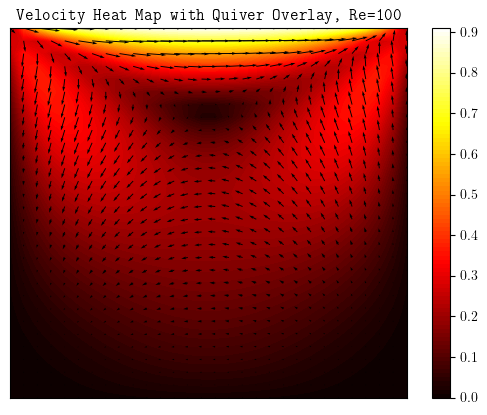

In [27]:
uvel = conv_sol[0][n**2:n**2 + n*(n+1)].reshape(n,(n+1))
vvel = conv_sol[0][n**2 + n*(n+1):].reshape((n+1),n)
pressure = conv_sol[0][:n**2].reshape(n,n)
px = np.linspace(h/2,1-(h/2),n)
py = np.linspace(h/2,1-(h/2),n)
ux = np.linspace(0,1,n+1)
uy = np.linspace(h/2,1-(h/2),n)
vx = np.linspace(h/2,1-(h/2),n)
vy = np.linspace(0,1,n+1)
uvel_interp = np.zeros((n,n)); vvel_interp = np.zeros((n,n))
uvel_interp = (uvel[:,:-1] + uvel[:,1:]) / 2
vvel_interp = (vvel[:-1,:] + vvel[1:,:]) / 2
X, Y = np.meshgrid(px,py)

fig, ax = plt.subplots()
cs = ax.contourf(-px,-py,np.hypot(uvel_interp,vvel_interp),levels=100,cmap='hot')
# cs = ax.contourf(-px,-py,uvel_interp,levels=100,cmap='hot')
# cs = ax.contourf(-px,-py,pressure,levels=100,cmap='hot')
cbar = fig.colorbar(cs)
ax.quiver(-px,-py,uvel_interp,vvel_interp)
plt.tick_params(
    bottom=False,
    top=False,
    labelbottom=False,
    left =False,
    labelleft=False)
ax.set_title("Velocity Heat Map with Quiver Overlay, Re=100")

0.3381844720827317
0.8889994498526856


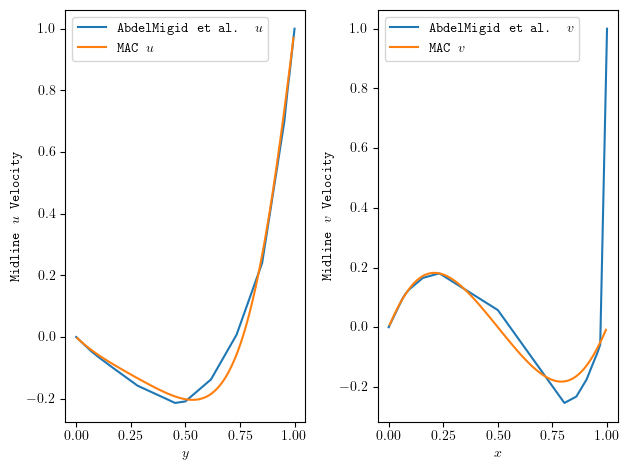

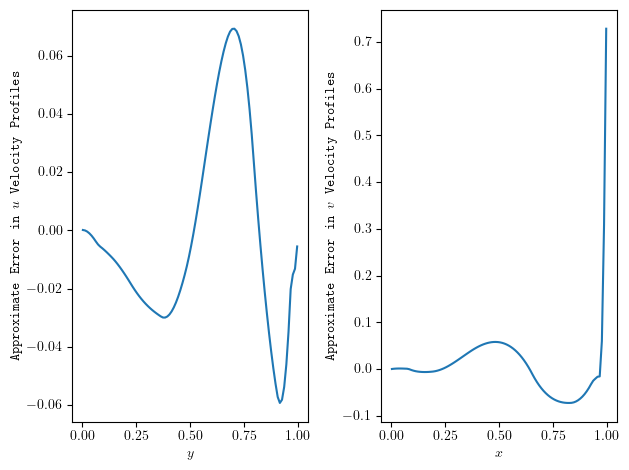

In [15]:
# Velocities -- compared against AbdelMigid, Saqr, Kotb, Aboelfarag

# tabulated u-velocity profiles along a vertical line passing through the geometric center of the cavity at Re=100
uvel_y = np.array([1.0,0.9766,0.9688,0.9609,0.9531,0.8516,0.7344,0.6172,0.5000,0.4531,0.2813,0.1719,0.1016,0.0703,0.0625,0.0547,0.0])
char_uvel = np.array([1.0,0.8500,0.8057,0.7512,0.6982,0.2398,0.0070,-0.1379,-0.2091,-0.2140,-0.1580,-0.1019,-0.0648,-0.0469,-0.0419,-0.0368,0.0])

# tabulated v-velocity profiles along a horizontal line passing through the geometric center of the cavity at Re=100
vvel_x = np.array([1.0,0.9688,0.9609,0.9531,0.9453,0.9063,0.8594,0.8047,0.5,0.2344,0.2266,0.1563,0.0938,0.0781,0.0703,0.0625,0.0])
char_vvel = np.array([1.0,-0.0580,-0.0747,-0.0911,-0.1041,-0.1750,-0.2323,-0.2536,0.0575,0.1796,0.1794,0.1652,0.1266,0.1127,0.1040,0.0947,0.0])

# numerical results from MAC Discretization
mid_line_char_uvel = (uvel_interp[:,49] + uvel_interp[:,50])/2
mid_line_char_vvel = (vvel_interp[49,:] + vvel_interp[50,:])/2

# Viz
fig2, ax2 = plt.subplots(1,2)
ax2[0].plot(uvel_y,char_uvel,label="AbdelMigid et al. $u$")
ax2[1].plot(vvel_x,char_vvel,label="AbdelMigid et al. $v$")
ax2[0].plot(np.linspace(h/2,1-h/2,len(mid_line_char_uvel)),mid_line_char_uvel[::-1],label="MAC $u$")
ax2[1].plot(np.linspace(h/2,1-h/2,len(mid_line_char_vvel)),mid_line_char_vvel,label="MAC $v$")
ax2[0].set_xlabel("$y$")
ax2[0].set_ylabel("Midline $u$ Velocity")
ax2[1].set_xlabel("$x$")
ax2[1].set_ylabel("Midline $v$ Velocity")
ax2[0].legend(loc='upper left')
ax2[1].legend(loc='upper left')

plt.tight_layout()

# error analysis
from scipy.interpolate import interp1d
bc_char_uvel = interp1d(uvel_y,char_uvel,kind="quadratic")
bc_char_vvel = interp1d(vvel_x,char_vvel,kind="quadratic")
fig3, ax3 = plt.subplots(1,2)
ax3[0].plot(np.linspace(h/2,1-h/2,len(mid_line_char_uvel)), np.array(bc_char_uvel(np.linspace(h/2,1-h/2,len(mid_line_char_uvel))))-mid_line_char_uvel[::-1])
ax3[1].plot(np.linspace(h/2,1-h/2,len(mid_line_char_vvel)), np.array(bc_char_vvel(np.linspace(h/2,1-h/2,len(mid_line_char_vvel))))-mid_line_char_vvel)
ax3[0].set_xlabel("$y$")
ax3[0].set_ylabel("Approximate Error in $u$ Velocity Profiles")
ax3[1].set_xlabel("$x$")
ax3[1].set_ylabel("Approximate Error in $v$ Velocity Profiles")
plt.tight_layout()
print(np.sqrt(np.sum((np.array(bc_char_uvel(np.linspace(h/2,1-h/2,len(mid_line_char_uvel))))-mid_line_char_uvel[::-1])**2)))
print(np.sqrt(np.sum((np.array(bc_char_vvel(np.linspace(h/2,1-h/2,len(mid_line_char_vvel))))-mid_line_char_vvel)**2)))